In [1]:
!pip install torchsummary
!pip install torchvision
!pip install albumentations==0.4.5


In [0]:
from torchsummary import summary
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F
from albumentations.pytorch.transforms import ToTensor

In [3]:
from google.colab import drive
drive.mount('/content/drive')
import sys

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
sys.path.append('/content/drive/My Drive/EVA4/s8')
!ls '/content/drive/My Drive/EVA4/s8'
import albumentation_data


albumentation_data.py  GradCam.py   QuizDNN.py		 utils.py
albumentationdata.py   __init__.py  resnet18_arch.py
cnn_model.py	       main.py	    Session9_Quiz.ipynb
data_loader.py	       __pycache__  train_test.py


In [5]:
# Created folder EVA4 and s8 in EVA4. Upload the py files in to s8 
import sys
sys.path.append('/content/drive/My Drive/EVA4/s10')
!ls '/content/drive/My Drive/EVA4/s10'
import S11_Resnet
import data_loader
import GradCam
from lr_finder import LRFinder
from lrfinder_utils import LRUtils
from train_test import Trainer
import lr_rangefinder
#import albumentation_data

albumentation_data.py  data_loader.py  lrfinder_utils.py  resnet18_arch.py
albumentationdata.py   GradCam.py      lr_rangefinder.py  S11_Resnet.py
cnn_model.py	       lr_finder.py    __pycache__	  train_test.py


  pip install torch-lr-finder -v --global-option="amp"


<h3> Load Train & Test Data

In [6]:
train_loader, test_loader = albumentation_data.LoadData().load_data(512)

Files already downloaded and verified
Files already downloaded and verified


<h2>Load  Model </h2>
<h3> Updated the Model to Return log_softmax </h3>

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = S11_Resnet.ResnetS11().to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1, 256,

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lrrange = lr_rangefinder.lrRangeFinder(model,train_loader, device)
learning_rates,train_accuracy=lrrange.plot(epochs=10)


starting 1 epoch:



starting 2 epoch:



starting 3 epoch:



starting 4 epoch:



starting 5 epoch:



starting 6 epoch:



starting 7 epoch:



starting 8 epoch:



starting 9 epoch:



starting 10 epoch:


[1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0]
[0.029208574705924036, 0.02919805617559524, 0.02920940511621315, 0.029169822225765304, 0.029182555183531744, 0.029212726757369613, 0.029185600021258504, 0.029199993799603172, 0.02919694896187642, 0.02918172477324263]


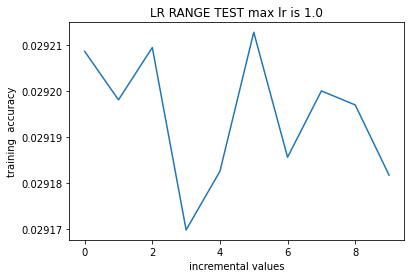

In [16]:
print(learning_rates)
print(train_accuracy)
max_lr=learning_rates[train_accuracy.index(max(train_accuracy))]
import matplotlib.pyplot as plt
plt.plot(train_accuracy)
plt.title('LR RANGE TEST max lr is {}'.format(max_lr))
plt.ylabel('training  accuracy')
plt.xlabel('incremental values')
plt.show()

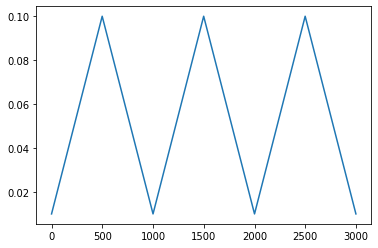

In [10]:
def annealing_factor(start,end,pct):
  return((end-start)*pct+start);

steps=1000
up=float(0.5*steps)-1
down=float(steps-up)-1
y=[annealing_factor(0.01,0.1,x/up) if(x<=up) else annealing_factor(0.1,0.01,(x-up)/down)for x in range(steps)]
y=y*3
x=list(range(len(y)))
plt.plot(x,y)
plt.show()

In [17]:
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
EPOCHS = 24
model = S11_Resnet.ResnetS11().to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
optimizer = optim.SGD(model.parameters(), lr=max_lr/10, momentum=0.9, nesterov=True, weight_decay=1e-2)
scheduler =OneCycleLR(optimizer, max_lr=max_lr/10, steps_per_epoch=int(len(train_loader))+1, epochs=EPOCHS,  pct_start=0.2, div_factor=10, final_div_factor=1 )
criterion = nn.CrossEntropyLoss()
trainer = Trainer()
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1, 'LR:', optimizer.param_groups[0]['lr'])
    trainer.train(model, device, train_loader, optimizer,criterion)
    trainer.test(model, device, test_loader)
    scheduler.step(trainer.test_losses[epoch])

  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 1 LR: 0.009999999999999995


Loss=2.099698066711426 Batch_id=97 Accuracy=18.20: 100%|██████████| 98/98 [00:19<00:00,  4.96it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 2.0158, Accuracy: 2632/10000 (26.32%)

EPOCH: 2 LR: 0.01000401283241771


Loss=1.6166108846664429 Batch_id=97 Accuracy=32.74: 100%|██████████| 98/98 [00:20<00:00,  4.89it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.6598, Accuracy: 4136/10000 (41.36%)

EPOCH: 3 LR: 0.01000272070771882


Loss=1.444103479385376 Batch_id=97 Accuracy=45.59: 100%|██████████| 98/98 [00:20<00:00,  4.85it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.8589, Accuracy: 3644/10000 (36.44%)

EPOCH: 4 LR: 0.01000341254002278


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.2601, Accuracy: 5551/10000 (55.51%)

EPOCH: 5 LR: 0.01000156806970759


Loss=1.0048478841781616 Batch_id=97 Accuracy=61.80: 100%|██████████| 98/98 [00:20<00:00,  4.89it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.9505, Accuracy: 6622/10000 (66.22%)

EPOCH: 6 LR: 0.010000892288816815


Loss=0.8911552429199219 Batch_id=97 Accuracy=67.56: 100%|██████████| 98/98 [00:19<00:00,  4.90it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.7698, Accuracy: 7409/10000 (74.09%)

EPOCH: 7 LR: 0.010000585157097716


Loss=0.8128381371498108 Batch_id=97 Accuracy=71.51: 100%|██████████| 98/98 [00:19<00:00,  4.95it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.6662, Accuracy: 7774/10000 (77.74%)

EPOCH: 8 LR: 0.010000438346098955


Loss=0.8228377103805542 Batch_id=97 Accuracy=74.28: 100%|██████████| 98/98 [00:19<00:00,  4.96it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.7218, Accuracy: 7544/10000 (75.44%)

EPOCH: 9 LR: 0.010000514478370942


Loss=0.7123433351516724 Batch_id=97 Accuracy=76.58: 100%|██████████| 98/98 [00:20<00:00,  4.90it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.5698, Accuracy: 8071/10000 (80.71%)

EPOCH: 10 LR: 0.010000320647976069


Loss=0.595660388469696 Batch_id=97 Accuracy=77.90: 100%|██████████| 98/98 [00:19<00:00,  4.92it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.5851, Accuracy: 8029/10000 (80.29%)

EPOCH: 11 LR: 0.010000338059826294


Loss=0.6886689066886902 Batch_id=97 Accuracy=78.91: 100%|██████████| 98/98 [00:19<00:00,  4.90it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.6094, Accuracy: 7961/10000 (79.61%)

EPOCH: 12 LR: 0.01000036673417061


Loss=0.49106112122535706 Batch_id=97 Accuracy=79.94: 100%|██████████| 98/98 [00:19<00:00,  4.94it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.5656, Accuracy: 8072/10000 (80.72%)

EPOCH: 13 LR: 0.01000031594307324


Loss=0.5077537894248962 Batch_id=97 Accuracy=80.31: 100%|██████████| 98/98 [00:19<00:00,  4.96it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.5516, Accuracy: 8145/10000 (81.45%)

EPOCH: 14 LR: 0.010000300442152457


Loss=0.6080577969551086 Batch_id=97 Accuracy=80.84: 100%|██████████| 98/98 [00:19<00:00,  4.94it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.5949, Accuracy: 8043/10000 (80.43%)

EPOCH: 15 LR: 0.010000349548310306


Loss=0.6341595649719238 Batch_id=97 Accuracy=80.90: 100%|██████████| 98/98 [00:19<00:00,  4.98it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.5741, Accuracy: 8089/10000 (80.89%)

EPOCH: 16 LR: 0.010000325467536708


Loss=0.6113284826278687 Batch_id=97 Accuracy=81.34: 100%|██████████| 98/98 [00:19<00:00,  4.97it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.5916, Accuracy: 7955/10000 (79.55%)

EPOCH: 17 LR: 0.01000034558129323


Loss=0.5877965092658997 Batch_id=97 Accuracy=81.75: 100%|██████████| 98/98 [00:19<00:00,  5.02it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.4744, Accuracy: 8398/10000 (83.98%)

EPOCH: 18 LR: 0.010000222252510613


Loss=0.5977994203567505 Batch_id=97 Accuracy=82.12: 100%|██████████| 98/98 [00:19<00:00,  4.94it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.6005, Accuracy: 7888/10000 (78.88%)

EPOCH: 19 LR: 0.010000356052762963


Loss=0.5019727349281311 Batch_id=97 Accuracy=82.19: 100%|██████████| 98/98 [00:19<00:00,  4.94it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.5255, Accuracy: 8210/10000 (82.10%)

EPOCH: 20 LR: 0.01000027273029308


Loss=0.5042706727981567 Batch_id=97 Accuracy=82.19: 100%|██████████| 98/98 [00:19<00:00,  4.95it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.5013, Accuracy: 8304/10000 (83.04%)

EPOCH: 21 LR: 0.010000248207216511


Loss=0.5459935069084167 Batch_id=97 Accuracy=82.92: 100%|██████████| 98/98 [00:19<00:00,  4.92it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.5695, Accuracy: 8089/10000 (80.89%)

EPOCH: 22 LR: 0.01000032034383408


Loss=0.5288710594177246 Batch_id=97 Accuracy=82.72: 100%|██████████| 98/98 [00:19<00:00,  5.05it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.4864, Accuracy: 8368/10000 (83.68%)

EPOCH: 23 LR: 0.010000233637599568


Loss=0.5460594296455383 Batch_id=97 Accuracy=82.95: 100%|██████████| 98/98 [00:19<00:00,  5.03it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.4699, Accuracy: 8434/10000 (84.34%)

EPOCH: 24 LR: 0.010000218063267632


Loss=0.5173178911209106 Batch_id=97 Accuracy=82.90: 100%|██████████| 98/98 [00:19<00:00,  4.97it/s]



Test set: Average loss: 0.5101, Accuracy: 8253/10000 (82.53%)

